DATA QUALITY ASSESSMENT

Dataset shape: (541909, 8)
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Unique customers: 4,372
Unique products: 4,070

=== MISSING VALUES ===
             Missing  Percentage
CustomerID    135080   24.926694
Description     1454    0.268311
StockCode          0    0.000000
InvoiceNo          0    0.000000
Quantity           0    0.000000
InvoiceDate        0    0.000000
UnitPrice          0    0.000000
Country            0    0.000000

=== DATA QUALITY ISSUES ===

 Returns/Cancellations: 10,624 (2.0%)

 Negative Price Error: 2,517 (0.5%)

Quantity stats: count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Top 5 extreme quantites:
        Quantity                        Description  UnitPrice
540421     80995        PAPER CRAFT , LITTLE BIRDIE       2.08
61619      74215     MEDIUM CERAMIC 

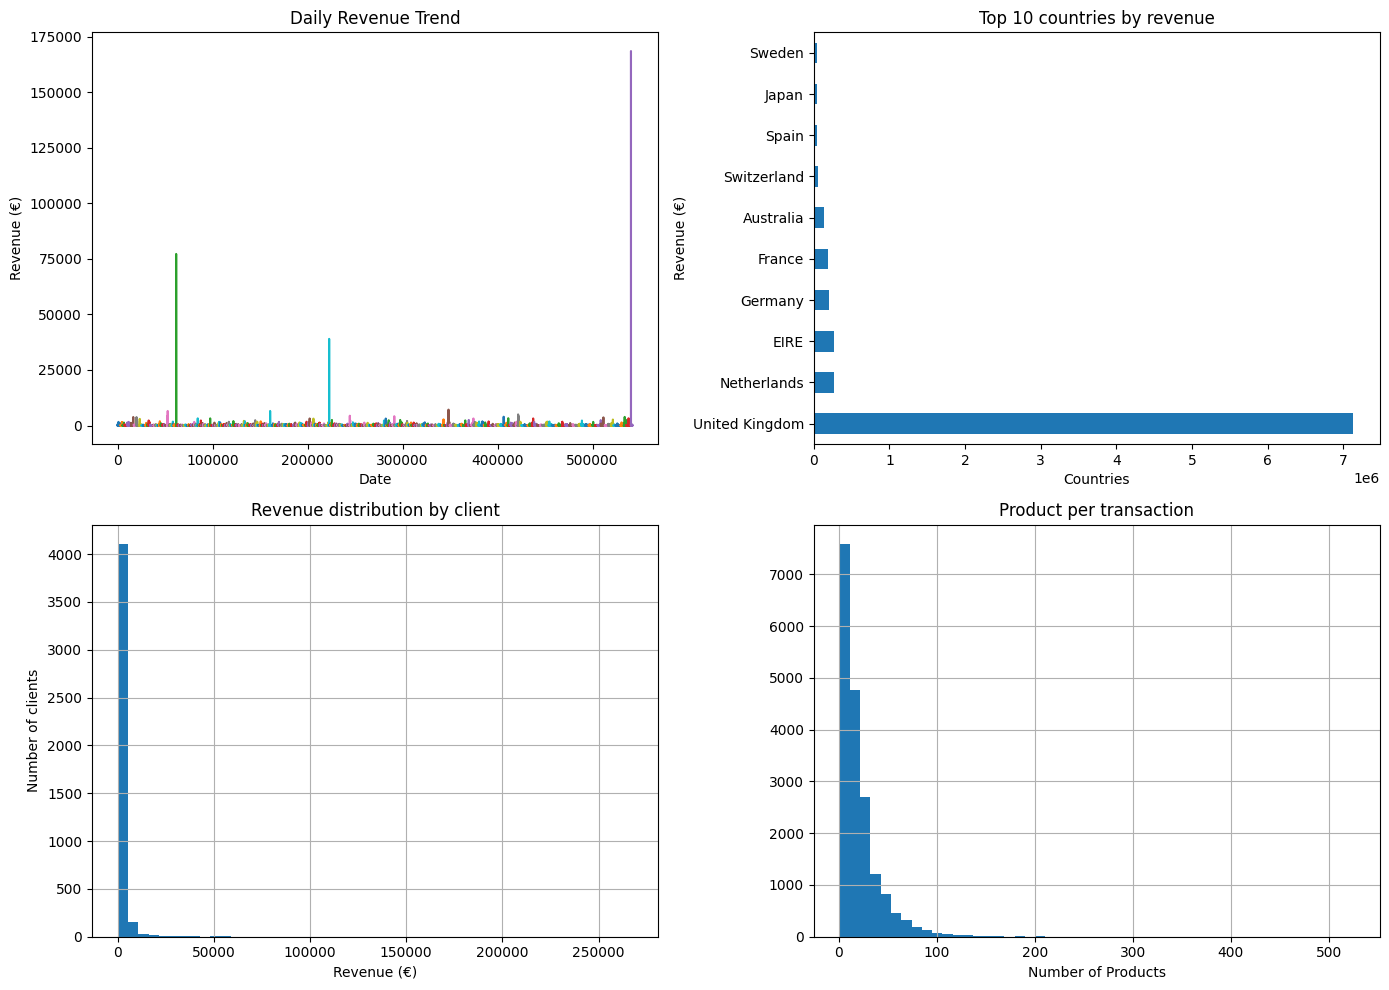


 Cleaned data base saved to data/online_retail_clean.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# ============================================================================
# 00_DATA_CLEANING_EDA.ipynb
# ============================================================================

## 1. INITIAL DATA INSPECTION
retail = pd.read_csv('../data/data.csv',
                     encoding='latin1',
                     parse_dates=['InvoiceDate'])


print("="*70)
print("DATA QUALITY ASSESSMENT")
print("="*70)

print(f"\nDataset shape: {retail.shape}")
print(f"Date range: {retail['InvoiceDate'].min()} to {retail['InvoiceDate'].max()}")
print(f"Unique customers: {retail['CustomerID'].nunique():,}")
print(f"Unique products: {retail['StockCode'].nunique():,}")

## 2. MISSING VALUES ANALYSIS

print("\n=== MISSING VALUES ===")
missing= retail.isna().sum()
missing_pct= (missing/len(retail))*100
missing_df= pd.DataFrame({
    'Missing' : missing, 
    'Percentage' : missing_pct
}).sort_values('Percentage',ascending=False)
print(missing_df)

# BUSINESS DECISION: 
# CustomerID missing (X%) → REMOVE (can't analyze without customer)
# Description missing (Y%) → KEEP (can use StockCode)

# DATA QUALITY ISSUES
print('\n=== DATA QUALITY ISSUES ===')

# Issue 1: Negative quantities (returns)
returns = retail[retail['Quantity']<0]
print(f'\n Returns/Cancellations: {len(returns):,} ({len(returns)/len(retail)*100:.1f}%)')
# Decision: Separate analysis or exclude

# Issue 2: Zero/negative prices
negative_price = retail[retail['UnitPrice']<=0]
print(f'\n Negative Price Error: {len(negative_price):,} ({len(negative_price)/len(retail)*100:.1f}%)')
# Decision: REMOVE (data errors)

# Issue 3: Extreme outliers
quantity_stats = retail['Quantity'].describe()
print(f'\nQuantity stats: {quantity_stats}')
print(f'\nTop 5 extreme quantites:')
print(retail.nlargest(5,'Quantity')[['Quantity', 'Description', 'UnitPrice']])

# Issue 4: Test transactions (StockCode patterns)
# Hacer identificacion de StockCode
# Test length
cond_len5 = retail['StockCode'].str.len()==5
cond_len5_digit = retail['StockCode'].str[:5].str.isdigit()
cond_len6 = retail['StockCode'].str.len()==6
cond_len6_digit = retail['StockCode'].str[-1]
is_valid_sku = cond_len5 | cond_len6
print(f'Stock Codes with 5 digit patterns: {cond_len6_digit}')
print(f'Stock Codes with 6 digit patterns: {cond_len5_digit}')
# Decision: no clear SKU patter based on lenght and structure. I am keeping StockCode as-is for traceability

## 4. CLEANING PIPELINE

print("="*70)
print("CLEANING PIPELINE")
print("="*70)

retail_clean = retail.copy()
original_len = len(retail)

# Step 1: 24.9% of transactions are missing CUSTOMER ID. Since my analysis focused on customer-level behavior, I am removing these rows.
before = len(retail_clean)
retail_clean = retail_clean[retail_clean['CustomerID'].notna()]
after = len(retail_clean)
print(f"1. Removed missing Customer ID: {before - after:,} rows")

# Step 2: Remove invalid prices
before = len(retail_clean)
retail_clean = retail_clean[retail_clean['UnitPrice']>0]
after  = len(retail_clean)
print(f"2. Removed invalid Unit Prices: {before - after:,} total removed")

# Step 3: Remove returns (or keep them for separate analysis)
before = len(retail_clean)
retail_clean = retail_clean[retail_clean['Quantity']>0]
after = len(retail_clean)
print(f"3. Removed returns: {before - after:,} total removed")

# Step 4: Remove test codes: recalculate test_codes/test description from retail_clean
before = len(retail_clean)
test_codes = retail_clean['StockCode'].str.contains('TEST|BANK|POST|DOT|AMAZONFEE', na=False)
test_description = retail_clean['Description'].str.contains('TEST|BANK|POST|DOT|AMAZONFEE', na=False, case = False)

print(f'\nTest/Administrative descriptions: {len(retail_clean[test_description]):,}')
retail_clean = retail_clean[~test_codes & ~test_description]
after  = len(retail_clean)
print(f"4. Removed test codes and test descriptions: {before - after:,} total removed")
print( f" Original rows: {original_len}")
print( f" Cleaned rows: {len(retail_clean)}")
print( f" Total removed; {original_len - len(retail_clean)}")

# 5. CREATE DERIVED COLUMNS
retail_clean['Revenue'] = retail_clean['Quantity'] * retail_clean['UnitPrice']
retail_clean['Year'] = retail_clean['InvoiceDate'].dt.year
retail_clean['Month']= retail_clean['InvoiceDate'].dt.month
retail_clean['DayOfWeek']= retail_clean['InvoiceDate'].dt.dayofweek
retail_clean['Hour']= retail_clean['InvoiceDate'].dt.hour


# 6. FINAL DATA SET REVIEW
print("\n" + "="*70)
print("CLEANED DATASET SUMMARY")
print("="*70)

print(f"Original dataset: {original_len:,}")
print(
    f"Cleaned dataset: {len(retail_clean):,} "
    f"({(len(retail_clean) / original_len * 100):.1f}%)"
)
print(f"Total removed: {original_len - len(retail_clean):,}")
print(f"Customers: {retail_clean['CustomerID'].nunique():,} unique CustomerID")
print(f"Products: {retail_clean['StockCode'].nunique():,} unique StockCode")
print(f"Date range: {retail_clean['InvoiceDate'].min()} to {retail_clean['InvoiceDate'].max()}")
print(f"Total revenue: {retail_clean['Revenue'].sum():,.2f}€")

## 7. VISUAL REPRESENTATIONS

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Revenue over time
daily_revenue = retail_clean.groupby(retail_clean['InvoiceDate'].dt.date)['Revenue']
daily_revenue.plot(ax=axes[0,0])
axes[0,0].set_title('Daily Revenue Trend')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Revenue (€)')


# 2. Top 10 countries
retail_clean.groupby('Country')['Revenue'].sum().nlargest(10).plot(kind='barh',ax=axes[0,1])
axes[0,1].set_title('Top 10 countries by revenue')
axes[0,1].set_xlabel('Countries')
axes[0,1].set_ylabel('Revenue (€)')


# 3. Revenue distribution by client
customer_revenue = retail_clean.groupby('CustomerID')['Revenue'].sum()
customer_revenue.hist(bins=50, ax=axes[1,0])
axes[1,0].set_title('Revenue distribution by client')
axes[1,0].set_xlabel('Revenue (€)')
axes[1,0].set_ylabel('Number of clients')


# 4. Products by transaction size
products_per_transaction = retail_clean.groupby('InvoiceNo').size()
products_per_transaction.hist(bins=50, ax=axes[1,1])

axes[1,1].set_title('Product per transaction')
axes[1,1].set_xlabel('Number of Products')


plt.tight_layout()
plt.show()

## 8. SAVED CLEAN DATA

retail_clean.to_csv('online_retail_clean.csv', index=False)
print(f'\n Cleaned data base saved to data/online_retail_clean.csv')
